In [1]:
using Catlab, Catlab.CategoricalAlgebra, Catlab.Programs, Catlab.WiringDiagrams, Catlab.Graphics
using AlgebraicPetri
using AlgebraicDynamics.UWDDynam,AlgebraicDynamics.DWDDynam
using LabelledArrays
using OrdinaryDiffEq, DelayDiffEq, DifferentialEquations # This is from SciML
using Plots
using JSON: parse as parse_json

## Compartmental Covid Model
https://www.sciencedirect.com/science/article/pii/S0960077921000424

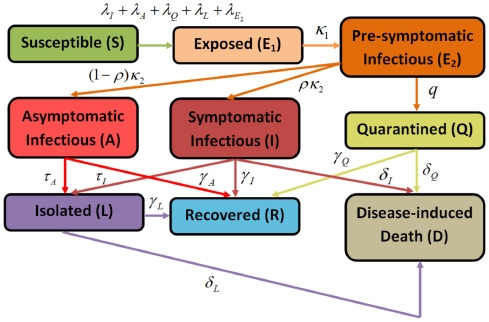

In this model, The susceptible compartment can only ever decrease in size (ignores the fact of Covid reinfection).

`Isolated = Hospitalized` Isolation separates sick people with a contagious disease from people who are not sick. Quarantine separates and restricts the movement of people who were exposed to a contagious disease to see if they become sick. Isolation is for people who are already sick.

https://www.cdc.gov/quarantine/index.html

### Next steps
These changes would be hard to do without rewriting the differential equations and recreating the.
- Allow recovered people to return to susceptible people to return to Recovered State
- Remove quarantine compartment. Exposure to Quarantine is no longer relevant.

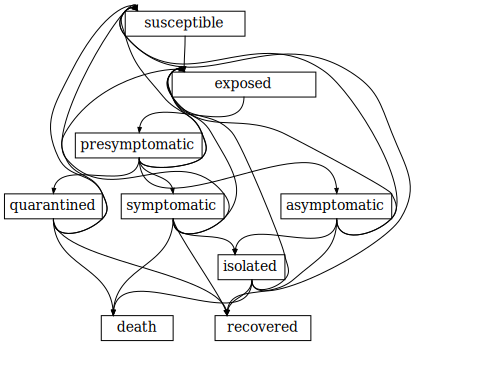

In [2]:
compartments = WiringDiagram([], [:susceptible, :exposed, :presymptomatic,
        :symptomatic, :asymptomatic, :quarantined, :isolated, :recovered, :death ])

susceptible_box  = add_box!(compartments, Box(
        :susceptible, [:E₂, :A, :I, :Q, :L], [:S]
))
exposed_box  = add_box!(compartments, Box(
        :exposed, [:S, :E₂, :A, :I, :Q, :L], [:E₁]
))
presymptomatic_box  = add_box!(compartments, Box(
        :presymptomatic, [:E₁], [:E₂]
))
symptomatic_box  = add_box!(compartments, Box(
        :symptomatic, [:E₂], [:I]
))
asymptomatic_box  = add_box!(compartments, Box(
        :asymptomatic, [:E₂], [:A]
))
quarantined_box  = add_box!(compartments, Box(
        :quarantined, [:E₂], [:Q]
))
isolated_box  = add_box!(compartments, Box(
        :isolated, [:I, :A], [:L]
))
recovered_box  = add_box!(compartments, Box(
        :recovered, [:I, :A, :Q, :L], [:R]
))
death_box  = add_box!(compartments, Box(
        :death, [:I, :L, :Q], [:D]
))


# Why is this step necessary/ Is it necessary?
add_wires!(compartments, Pair[     
    (susceptible_box, 1)  => (exposed_box, 1),
    (exposed_box, 1)  => (presymptomatic_box, 1),
        
    (presymptomatic_box, 1)  => (symptomatic_box, 1),
    (presymptomatic_box, 1)  => (asymptomatic_box, 1),
    (presymptomatic_box, 1)  => (quarantined_box, 1),

    (asymptomatic_box, 1)  => (isolated_box, 1),
    (asymptomatic_box, 1)  => (recovered_box, 1),
        
    (symptomatic_box, 1)  => (isolated_box, 1),
    (symptomatic_box, 1)  => (recovered_box, 1),
    (symptomatic_box, 1)  => (death_box, 1),
        
    (quarantined_box, 1)  => (recovered_box, 1),
    (quarantined_box, 1)  => (death_box, 1),
        
    (isolated_box, 1)  => (recovered_box, 1),
    (isolated_box, 1)  => (death_box, 1),
        
    # Loop back to Susceptible [IS THIS NECESSARY?]
    (presymptomatic_box,1) => (susceptible_box,1),
    (asymptomatic_box,1) => (susceptible_box,1),
    (symptomatic_box,1) => (susceptible_box,1), 
    (quarantined_box,1) => (susceptible_box,1), 
    (isolated_box,1) => (susceptible_box,1), 
    
    # Loop back to Exposed [IS THIS NECESSARY?]
    (presymptomatic_box,1) => (exposed_box,1),
    (asymptomatic_box,1) => (exposed_box,1),
    (symptomatic_box,1) => (exposed_box,1), 
    (quarantined_box,1) => (exposed_box,1), 
    (isolated_box,1) => (exposed_box,1),
    ]
)

to_graphviz(compartments)

# (S, E₁, E₂, A, I, Q, L, R, D, Iv, R)

In [3]:
λ = function(βₓ, m, ζ, compartment, total_population)
    coefficient = βₓ * (1 - m*ζ)
    ratio = compartment/total_population
    coefficient * ratio
end

prefillλ = function(m, ζ, total_population)
   (βₓ, compartment) -> λ(βₓ, m, ζ, compartment, total_population)
end

dSdt = function(u,x,p,t)
  S = u[1]
  (E₂, A, I, Q, L) = x
  (;βI, βA, βQ, βL, βE₂, m, ζ) = p
  genλ = prefillλ(m, ζ, sum(x))
  λE₂, λA, λI, λQ, λL = [ genλ(β, compartment) for (β, compartment) in [
    (βE₂,E₂), (βA, A), (βI, I), (βQ, Q), (βL,L)          
  ]]
  -(λE₂ + λA + λI + λQ + λL) * S
end
susceptible = ContinuousMachine{Float64}(5,1,1, dSdt, (u, p, t) -> u)

dE₁dt = function(u,x,p,t)
  E₁ = u[1]
  (S, E₂, A, I, Q, L) = x
  (;βI, βA, βQ, βL, βE₂, m, ζ, κ₁) = p
  genλ = prefillλ(m, ζ, sum(x))
  λE₂, λA, λI, λQ, λL = [ genλ(β, compartment) for (β, compartment) in [
    (βE₂,E₂), (βA, A), (βI, I), (βQ, Q), (βL,L)          
  ]]
  (λE₂ + λA + λI + λQ + λL)*S - κ₁*E₁
end
exposed = ContinuousMachine{Float64}(6,1,1, dE₁dt, (u, p, t) -> u)

dE₂dt = function(u,x,p,t)
  E₂ = u[1]
  (E₁,) = x
  (;κ₁,κ₂,q) = p
  κ₁*E₁ - (κ₂ + q)*E₂
end
presymptomatic = ContinuousMachine{Float64}(1,1,1, dE₂dt, (u, p, t) -> u)


dIdt = function(u,x,p,t)
  I = u[1]
  (E₂,) = x
  (;ρ, κ₂, τI, γI, δI) = p
  ρ*κ₂*E₂ − (τI + γI + δI)*I
end
symptomatic = ContinuousMachine{Float64}(1,1,1, dIdt, (u, p, t) -> u)


dAdt = function(u,x,p,t)
  A = u[1]
  (E₂,) = x
  (;ρ, κ₂, τA, γA) = p
  (1 − ρ)*κ₂*E₂ − (τA + γA)*A
end
asymptomatic = ContinuousMachine{Float64}(1,1,1, dAdt, (u, p, t) -> u)


dQdt = function(u,x,p,t)
  Q = u[1]
  (E₂,) = x
  (;q, γQ, δQ) = p
  q*E₂ − (γQ + δQ)*Q
end
quarantined = ContinuousMachine{Float64}(1,1,1, dQdt, (u, p, t) -> u)


dLdt = function(u,x,p,t)
  L = u[1]
  (A, I) = x
  (;τI, τA, γL, δL) = p
  τI*I + τA*A − (δL + γL)*L
end
isolated = ContinuousMachine{Float64}(2,1,1, dLdt, (u, p, t) -> u)


dRdt = function(u,x,p,t)
  R = u[1]
  (I, A, Q, L) = x
  (;γI, γA, γQ, γL) = p
  γI*I + γA*A + γQ*Q + γL*L
end
recovered = ContinuousMachine{Float64}(4,1,1, dRdt, (u, p, t) -> u)


dDdt = function(u,x,p,t)
  D = u[1]
  (I, L, Q) = x
  (;δI, δL, δQ) = p
  δI*I + δL*L + δQ*Q
end
death = ContinuousMachine{Float64}(3,1,1, dDdt, (u, p, t) -> u)

ContinuousMachine(ℝ^1 × ℝ^3 → ℝ^1)

In [4]:
compartmental_system = oapply(compartments, [
    susceptible, exposed, presymptomatic, symptomatic, asymptomatic, quarantined, isolated, recovered, death
])

ContinuousMachine(ℝ^9 × ℝ^0 → ℝ^9)

In [5]:
pops = open(parse_json, "../../configs/population.json")
state = Vector{Float64}([
    pops["susceptible"],
    pops["exposed"],
    pops["presymptomatic"],
    pops["symptomatic_infected"],
    pops["asymptomatic_infected"],
    pops["quarantined"],
    pops["isolated"],
    pops["recovered"],
    pops["death"],
  ])


params = open(parse_json, "../../configs/params.json")
parameters = LVector(
    βI = params["βI"],
    βA = params["βA"],
    βQ = params["βQ"],
    βL = params["βL"], 
    βE₂ = params["βE₂"], 
    m = params["m"],
    ζ = params["ζ"],
    κ₁ = params["κ₁"], 
    κ₂ = params["κ₂"], 
    ρ = params["ρ"],
    q = params["q"],
    τI = params["τI"],
    τA = params["τA"],
    γI = params["γI"],
    γA = params["γA"],
    γQ = params["γQ"],
    γL = params["γL"],
    δI = params["δI"],
    δL = params["δL"],
    δQ = params["δQ"],
  )

tspan = (0.0, 365.0)

(0.0, 365.0)

In [7]:
prob = ODEProblem(compartmental_system, state, tspan, parameters)
sol = solve(prob, Tsit5());
println(sol)

ODESolution{Float64, 2, Vector{Vector{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{Float64}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, false, LArray{Float64, 1, Vector{Float64}, (:βI, :βA, :βQ, :βL, :βE₂, :m, :ζ, :κ₁, :κ₂, :ρ, :q, :τI, :τA, :γI, :γA, :γQ, :γL, :δI, :δL, :δQ)}, ODEFunction{false, SciMLBase.AutoSpecialize, AlgebraicDynamics.DWDDynam.var"#42#43"{ContinuousMachine{Float64, AlgebraicDynamics.DWDDynam.DirectedInterface{Float64}}, Vector{Float64}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, OrdinaryDiffEq.InterpolationData{ODEFunction{false, SciMLBase.AutoSpecialize, AlgebraicDynamics.DWDDynam.v

, 0.014568781494901761, 0.013121060201770363, 133.78078947199114, 0.05444495721552744], [39830.01521608269, 2.1401030757011686e-9, 6.23288172599448e-7, -4.232469542317119e-7, -1.610877858106817e-7, 0.012509528769429193, 0.011261712034284116, 133.8262719313539, 0.05446678959263168], [32651.83192790141, 1.2579998128733307e-9, 6.231008186411205e-7, -4.233311337466416e-7, -1.8764803479593249e-7, 0.010741341951763694, 0.009665844567396269, 133.8653177791872, 0.054485532301473], [26767.324004908172, 7.394815225990335e-10, 6.22963640808417e-7, -4.2336222726800957e-7, -2.042100437495864e-7, 0.009223083433849946, 0.008296125807969144, 133.89883784873595, 0.05450162254864948], [21943.345300350396, 4.346857012321591e-10, 6.228428451764043e-7, -4.23353201001747e-7, -2.14525333947682e-7, 0.00791942800441215, 0.007120510952536377, 133.92761412044288, 0.054515435693014], [17988.762494101902, 2.555200032264589e-10, 6.227185391761051e-7, -4.233116578666022e-7, -2.2093773700668435e-7, 0.0068000420890383

 0.054599166765239814], [1.5828265691045666, 3.662443301755024e-21, 5.915628460396922e-7, -4.021908543883129e-7, -2.2001986554257232e-7, 5.035185836722267e-6, 4.69954849930379e-6, 134.10206593199507, 0.05459917588428924], [1.2975700893773414, 2.152870481169297e-21, 5.915165717381759e-7, -4.0215939348613033e-7, -2.2000265475049343e-7, 4.289078010084257e-6, 4.040562240321463e-6, 134.1020822408901, 0.05459918371287617], [1.063722068310183, 1.2655068273875317e-21, 5.914768349938871e-7, -4.021323773283978e-7, -2.199878754706267e-7, 3.6484267890771996e-6, 3.4749590909770028e-6, 134.10209624186126, 0.05459919043361473], [0.8720178696371267, 7.438934584802084e-22, 5.914426445531863e-7, -4.0210913198323216e-7, -2.1997515902632028e-7, 3.0983270025209138e-6, 2.9895062336604773e-6, 134.10210826150455, 0.054599196203277384], [0.7148624471237237, 4.372770406115525e-22, 5.914135045118381e-7, -4.0208932029590677e-7, -2.1996432097603577e-7, 2.62597990771429e-6, 2.57284592769602e-6, 134.1021185802019, 0

, -2.4091161464733496e-7, 5.149421579623828e-8, 134.1021811215229, 0.05459923117750143], [6.279976198472704e-5, 6.240802501111334e-33, 5.912618406538474e-7, -4.0198620730120584e-7, -2.199079126642416e-7, -2.4127784674338896e-7, 5.117756588222715e-8, 134.1021811294491, 0.054599231181306156], [5.14818820435929e-5, 3.6684664607948296e-33, 5.912622000421898e-7, -4.0198645164160745e-7, -2.199080463314832e-7, -2.4159245707994625e-7, 5.090581748937857e-8, 134.10218113625388, 0.05459923118457254], [4.220373056835521e-5, 2.1563968622990896e-33, 5.912621635743663e-7, -4.01986426847925e-7, -2.199080327680142e-7, -2.4186245657984555e-7, 5.067254991418235e-8, 134.10218114209545, 0.054599231187376605], [3.4597703904537774e-5, 1.2675726326573899e-33, 5.912617312504751e-7, -4.019861329201939e-7, -2.1990787197385506e-7, -2.4209412774101244e-7, 5.0472305350423524e-8, 134.10218114711006, 0.054599231189783756], [2.836244752042652e-5, 7.451041726144432e-34, 5.912616453007537e-7, -4.0198607448480986e-7, -2.

, 2.598418799398635, 0.37511376865032825, 2.502133095859034, 0.0008006515829004762], [-1.5397587602523794e7, -2.4996224762393355, -4.096292732272064, -0.03854155937077919, 1.8934304552164003, 2.5982782634842687, 0.3751238763970903, 2.5023315714310987, 0.0008007094938730336], [-1.5397569877009729e7, -2.499614782292474, -4.096217209290092, -0.03856480874261625, 1.8933984796535137, 2.598243187335037, 0.37512639905918543, 2.5023811086436165, 0.0008007239477499184], [-1.5397569877230017e7, -2.4996147825494903, -4.0962172264536925, -0.03856480057811429, 1.893398486250225, 2.5982431945475573, 0.37512639805922643, 2.5023810983920196, 0.0008007239446085071]], [[-1.5397569877230017e7, -2.4996147825494903, -4.0962172264536925, -0.03856480057811429, 1.893398486250225, 2.5982431945475573, 0.37512639805922643, 2.5023810983920196, 0.0008007239446085071], [-1.5396141150837008e7, -2.498994630239004, -4.090130009802039, -0.04043869350300544, 1.8908212225334118, 2.5954160201124474, 0.3753297228798761, 2.

, -0.1957213761552648, -0.11054712104147763, 0.2727828206967564, 0.2653409958982288, 5.965700981733702, 0.0019545691389932012], [-1.0678200898843396e7, -0.9385412553297849, -0.1681435849594275, -0.15756910681329833, -0.14425491105014482, 0.20929974376579544, 0.24065859019064656, 6.03905924534878, 0.002010445732587125], [-1.0616697222180258e7, -0.9233900269353733, -0.1599862507217794, -0.15164279819235543, -0.15051891970429548, 0.19896177964797435, 0.23726409014151967, 6.049519006387145, 0.002017640812838851], [-1.0601419146387523e7, -0.9196698860473818, -0.15803296690377988, -0.15025342722784418, -0.15201059630880953, 0.19644954113439256, 0.23642293334125936, 6.051982093783736, 0.00201941104640209], [-1.0602658294163361e7, -0.9217602114585794, -0.16967035399492292, -0.15421137111131017, -0.14583386944399285, 0.20242737165530547, 0.2365248346816285, 6.044982531012586, 0.0020191928449194894]], [[-1.0602658294163361e7, -0.9217602114585794, -0.16967035399492292, -0.15421137111131017, -0.14

, -0.14772679712994743, -0.06762284287817422, 3.994995511098733, 0.0017212982843295302], [-3.898665434343547e6, -0.06351298421826604, -0.011343091834370628, -0.007523272700298744, -0.0870410053128168, -0.14424516722844105, -0.06615115350422365, 3.9811393985061216, 0.001713537691261827]], [[-3.898665434343547e6, -0.06351298421826604, -0.011343091834370628, -0.007523272700298744, -0.0870410053128168, -0.14424516722844105, -0.06615115350422365, 3.9811393985061216, 0.001713537691261827], [-3.751264409274306e6, -0.05709238660674147, -0.010195564078238753, -0.006762538547322998, -0.08155281482789406, -0.14304446016380307, -0.06900769159298184, 3.878380831637549, 0.0016782901200554923], [-3.610898237211885e6, -0.05182486888204989, -0.009255292419598458, -0.006138251841901126, -0.07642219317094026, -0.14125052346580771, -0.07112172983126144, 3.7756559417501667, 0.0016416462251399883], [-3.1493464046756597e6, -0.03399806581380742, -0.0060523637891587295, -0.004033277430186432, -0.06040618709768

, 1.3985931985756364, 0.0006606192356615136]], [[-953261.3966766624, -0.0014700109594981987, -0.0002644072436989275, -0.00017279230454522038, -0.0054798328164636124, -0.062062095940069145, -0.05233511671739903, 1.3985931985756364, 0.0006606192356615136], [-924917.6115629574, -0.0013531431750159516, -0.0002425382762008925, -0.0001596317933494124, -0.005132308286094588, -0.060701673621646614, -0.051363192079266574, 1.3667807433019017, 0.0006460456924519026], [-897449.6687089528, -0.0012520061926451277, -0.00022454037888977965, -0.00014761219243621354, -0.004818124342776677, -0.05935421803492333, -0.05037751403424971, 1.335467350160905, 0.0006316412429665479], [-806492.6856569523, -0.0009193171370441198, -0.0001530881359548394, -0.00011640121157029294, -0.0038013303689003707, -0.054860192875757316, -0.04706349199311054, 1.2310012226866363, 0.0005835339120515043], [-793981.3749107269, -0.0008623506955263999, -0.0001305186300516025, -0.0001180832868637572, -0.0036520238252158023, -0.0542570

, 0.4871674537491949, 0.00023335681820834406], [-233444.70096133344, -3.408016627839812e-5, -6.575121406059892e-6, -3.703263721901564e-6, -0.0002440535936547688, -0.02140427582322613, -0.019297763172224633, 0.47524693255495837, 0.00022767056372831088], [-226032.84867684645, -3.1371069992332556e-5, -6.17978419649278e-6, -3.3223143915504365e-6, -0.00022726912074231984, -0.0208799869365318, -0.018832468456985715, 0.4635634267408397, 0.00022209386843561474], [-201539.6063636333, -2.241060691151335e-5, 4.1273988389922854e-6, -8.18093199736043e-6, -0.00017578316355008149, -0.01913764011375757, -0.017281395766994233, 0.4246626600739465, 0.00020352328677077037], [-198161.1541282543, -2.0808679735979632e-5, 1.363536626208831e-5, -1.4260999585439054e-5, -0.00017040355261129647, -0.01890258443850549, -0.017069574395690942, 0.41934120541774234, 0.00020098479434866353], [-197332.2500655378, -2.0431112208201035e-5, 1.6250071415197976e-5, -1.5948128236442865e-5, -0.00016925559001534804, -0.0188447218

 -0.00669955994749266, 0.16360483596203323, 7.85150654839768e-5], [-56368.59473636782, -7.654061108922007e-7, -6.704807962817044e-7, 2.7227585404538397e-7, -9.150100655874458e-6, -0.007204532907764664, -0.00653442617852283, 0.15956781386450053, 7.657852767965472e-5], [-50237.52612430113, -5.458900438571299e-7, 7.4968152058651696e-6, -5.227845828388555e-6, -9.856445145649742e-6, -0.006601851810245214, -0.005983858474501243, 0.14613136214024083, 7.0132306375071e-5], [-49391.69171627387, -5.065440221681404e-7, 1.612591295343902e-5, -1.108514730031016e-5, -1.2682928023708937e-5, -0.006522411815777607, -0.005907885013257915, 0.14429640151392484, 6.925141524415519e-5], [-49184.18446227062, -4.97272115797237e-7, 1.851144453066791e-5, -1.2704795197612938e-5, -1.3479264331501758e-5, -0.006502929337493357, -0.005889127684585904, 0.14384412551902648, 6.903426591117806e-5], [-49310.030384841884, -5.347021840065266e-7, -1.125784596360975e-6, 6.371575209168751e-7, -6.461807264239984e-6, -0.006502059

 -0.0022446933376432795, 0.05483809780194174, 2.632273433194259e-5], [-12500.710078571128, -1.3240035299067037e-8, 7.570601041733309e-6, -5.150264200071112e-6, -3.0865769568323925e-6, -0.0022742161029006423, -0.002054682025274649, 0.050223405658498387, 2.4107027380045982e-5], [-12290.192427350155, -1.2285331309479217e-8, 1.6168986568224933e-5, -1.0995892597067347e-5, -6.26949661537389e-6, -0.002249181210212774, -0.00202803694801486, 0.04959662032118051, 2.380541045920983e-5], [-12238.546689818411, -1.2060357119172152e-8, 1.8546422665081606e-5, -1.2612206303971431e-5, -7.150159535535732e-6, -0.002243114039793333, -0.0020214455316587983, 0.04944225017351539, 2.3731101949880274e-5], [-12269.880642741322, -1.2968846589982443e-8, -1.0303508835834966e-6, 6.974030457635303e-7, 1.1942806679804507e-7, -0.0022375438829299286, -0.002025342190225787, 0.04948395233482829, 2.3752863785937673e-5]], [[-12269.880642741322, -1.2968846589982443e-8, -1.0303508835834966e-6, 6.974030457635303e-7, 1.19428066

 -2.825960414016927e-6, -0.0007846917510844932, -0.0007046487232923646, 0.01726284432660712, 8.285796018511663e-6], [-3058.0003032052855, -2.9792519140698097e-10, 1.6167116339508946e-5, -1.0991746093637731e-5, -6.022528731826594e-6, -0.0007783977697077229, -0.0006950322140775845, 0.01705138548126282, 8.183517673911004e-6], [-3045.1501637416964, -2.9246959773218504e-10, 1.85439143326204e-5, -1.2607678615327136e-5, -6.906395849541492e-6, -0.000776951712695853, -0.000692639639828929, 0.01699942432738035, 8.158361261837352e-6], [-3052.9462852587817, -3.144999532183327e-10, -1.0278018508046306e-6, 6.98704942684232e-7, 3.724642417088787e-7, -0.0007697492024093402, -0.0006950505967918595, 0.01700479939747485, 8.162705275210486e-6]], [[-3052.9462852587817, -3.144999532183327e-10, -1.0278018508046306e-6, 6.98704942684232e-7, 3.724642417088787e-7, -0.0007697492024093402, -0.0006950505967918595, 0.01700479939747485, 8.162705275210486e-6], [-2955.2710190964995, -2.8759610382807474e-10, -4.47535972

 -0.00024137200624520507, 0.005936067545416176, 2.848744001019654e-6], [-760.9096639504809, -7.2256456689269005e-12, 1.6145617709516162e-5, -1.0977059918211477e-5, -6.005382928475196e-6, -0.00027224219033933827, -0.00023760290446251346, 0.0058673266013991275, 2.8149730398278395e-6], [-757.7124193656366, -7.093346837523998e-12, 1.8519200093529656e-5, -1.2590807493145164e-5, -6.888184039836831e-6, -0.00027238523774228483, -0.00023665215645678913, 0.0058505558328445445, 2.806708744223025e-6], [-759.6519500365309, -7.627538048881053e-12, -1.0262047318054935e-6, 6.976926939523322e-7, 3.8131840574943073e-7, -0.0002646309149748625, -0.00023854837700629502, 0.0058434653455786975, 2.8050674521127987e-6]], [[-759.6519500365309, -7.627538048881053e-12, -1.0262047318054935e-6, 6.976926939523322e-7, 3.8131840574943073e-7, -0.0002646309149748625, -0.00023854837700629502, 0.0058434653455786975, 2.8050674521127987e-6], [-735.3494852410017, -6.975086229958444e-12, -4.468540495129057e-7, 3.0380478348904

, -9.567410822930627e-5, -8.242149003224052e-5, 0.0020436968471512695, 9.803361803743838e-7], [-189.36533306240065, -1.7532725176229176e-13, 1.6045415344573462e-5, -1.0908932794760844e-5, -5.967780990681653e-6, -9.802294039762539e-5, -8.066292582687463e-5, 0.0020239651987904376, 9.700954030640249e-7], [-188.56980074188718, -1.7211834606669337e-13, 1.8404123684426723e-5, -1.251256785797364e-5, -6.845054789546437e-6, -9.870717334769068e-5, -8.020805623366702e-5, 0.0020192777058448868, 9.676326442890622e-7], [-189.0522190124492, -1.8507156021709678e-13, -1.0193038809686199e-6, 6.930027388558151e-7, 3.7909661373137e-7, -9.080945616728185e-5, -8.19181458000178e-5, 0.0020079822946651046, 9.639619385393105e-7]], [[-189.0522190124492, -1.8507156021709678e-13, -1.0193038809686199e-6, 6.930027388558151e-7, 3.7909661373137e-7, -9.080945616728185e-5, -8.19181458000178e-5, 0.0020079822946651046, 9.639619385393105e-7], [-183.00529489105548, -1.692437503827762e-13, -4.439583568439614e-7, 3.0183769659

 1.5809820296483785e-5, -1.074875674823269e-5, -5.880144135725603e-6, -3.79817444265516e-5, -2.682841465702465e-5, 0.0007029737826172367, 3.360154231173794e-7], [-46.94139561052615, -4.179375814633303e-15, 1.8133770757603036e-5, -1.232876067809402e-5, -6.744490616545721e-6, -3.883998536420892e-5, -2.6546135252599207e-5, 0.0007024174612009717, 3.355388396249522e-7], [-47.06142681896584, -4.493716099848973e-15, -1.0038739554168682e-6, 6.825123076824452e-7, 3.733702023189237e-7, -3.0993363295589744e-5, -2.817206523019884e-5, 0.000689847792143235, 3.312306991130332e-7]], [[-47.06142681896584, -4.493716099848973e-15, -1.0038739554168682e-6, 6.825123076824452e-7, 3.733702023189237e-7, -3.0993363295589744e-5, -2.817206523019884e-5, 0.000689847792143235, 3.312306991130332e-7], [-45.55632719449416, -4.10944812942691e-15, -4.373064307686171e-7, 2.973152347460008e-7, 1.6264687767208935e-7, -3.0456446627896323e-5, -2.7434074706858953e-5, 0.0006732848528238209, 3.232290858307876e-7], [-44.104786749

 -5.789220802165122e-6, -1.7244542415908182e-5, -8.363887991449948e-6, 0.00024873041768312486, 1.179919288112943e-7], [-11.685271712610831, -1.0147609371639853e-16, 1.785346350452537e-5, -1.213818580521302e-5, -6.64023556471714e-6, -1.8152833111777978e-5, -8.142822495714661e-6, 0.0002495771954626392, 1.1819209179549741e-7], [-11.71516219046549, -1.0911169989736389e-16, -9.886845378963568e-7, 6.721853504892307e-7, 3.67721250281129e-7, -1.0404999934242172e-5, -9.72343788860723e-6, 0.000236707432486653, 1.1371325707830687e-7]], [[-11.71516219046549, -1.0911169989736389e-16, -9.886845378963568e-7, 6.721853504892307e-7, 3.67721250281129e-7, -1.0404999934242172e-5, -9.72343788860723e-6, 0.000236707432486653, 1.1371325707830687e-7], [-11.34044104857079, -9.9780024768274e-17, -4.306128803127888e-7, 2.92764434732349e-7, 1.6015775784572713e-7, -1.0369629392700552e-5, -9.439804708871828e-6, 0.0002312658881150106, 1.1105089287762226e-7], [-10.979057845552909, -9.182153556287642e-17, -5.11602589258

 [-2.9082082383475174, -2.4623765144388505e-18, 1.7699280843647496e-5, -1.203336033055796e-5, -6.582890419596307e-6, -1.1006642442900005e-5, -1.8303424729375452e-6, 9.384572675887771e-5, 4.3451898530504767e-8], [-2.9156509845989054, -2.6477707877831324e-18, -9.80592531601076e-7, 6.666837694952465e-7, 3.6471160766136004e-7, -3.3177507571675027e-6, -3.39033200264042e-6, 8.091504100493951e-5, 3.8929188247597125e-8]], [[-2.9156509845989054, -2.6477707877831324e-18, -9.80592531601076e-7, 6.666837694952465e-7, 3.6471160766136004e-7, -3.3177507571675027e-6, -3.39033200264042e-6, 8.091504100493951e-5, 3.8929188247597125e-8], [-2.8223774797265744, -2.4212899074263437e-18, -4.2700834613106897e-7, 2.903137894997816e-7, 1.588171387243488e-7, -3.454438810914216e-6, -3.262817945006596e-6, 7.929656036275965e-5, 3.810237265269695e-8], [-2.7324248805031437, -2.2281422581103305e-18, -5.07441077294304e-7, 3.449982732937246e-7, 1.8873247035391915e-7, -3.331847778791046e-6, -3.1897701649811802e-6, 7.727644

, -8.542791330370291e-6, 3.353037057746982e-7, 4.030732119191624e-5, 1.7758086701523424e-8], [-0.7255307598326651, -6.422594292929036e-20, -9.77344831321499e-7, 6.644757279344532e-7, 3.635036916287748e-7, -8.783305499900936e-7, -1.216753484279618e-6, 2.7362725909285227e-5, 1.32227559288396e-8]], [[-0.7255307598326651, -6.422594292929036e-20, -9.77344831321499e-7, 6.644757279344532e-7, 3.635036916287748e-7, -8.783305499900936e-7, -1.216753484279618e-6, 2.7362725909285227e-5, 1.32227559288396e-8], [-0.702318975550392, -5.873190588965539e-20, -4.2555607075882886e-7, 2.8932641871349e-7, 1.5827699471933245e-7, -1.0741533210912316e-6, -1.1428510660315122e-6, 2.705846268363273e-5, 1.3026951811917726e-8], [-0.6799337292442715, -5.4046543265515134e-20, -5.05772680255848e-7, 3.438639660353479e-7, 1.8811194421785038e-7, -1.0103243561703342e-6, -1.12216726443955e-6, 2.6327492463599743e-5, 1.2683304786144319e-8], [-0.6059681561754438, -3.854366610754656e-20, 7.198695968034522e-6, -4.894238543289775

], [-0.18052912625424106, -1.5576270356212354e-21, -9.761670634631192e-7, 6.636749889015657e-7, 3.6306564465572734e-7, -3.8773956545395594e-8, -4.708847935121438e-7, 8.957289479884381e-6, 4.387686851036802e-9]], [[-0.18052912625424106, -1.5576270356212354e-21, -9.761670634631192e-7, 6.636749889015657e-7, 3.6306564465572734e-7, -3.8773956545395594e-8, -4.708847935121438e-7, 8.957289479884381e-6, 4.387686851036802e-9], [-0.17475333594156484, -1.4243804736482297e-21, -4.2502872665662267e-7, 2.8896788880168306e-7, 1.5808085973827968e-7, -2.5493777139806366e-7, -4.153837404171401e-7, 9.10472876987261e-6, 4.408767259986735e-9], [-0.16918322328989743, -1.3107472711470049e-21, -5.051678623270948e-7, 3.4345276333534917e-7, 1.8788699440874986e-7, -2.1133611293627326e-7, -4.1266991408597756e-7, 8.816865799797922e-6, 4.27781323677793e-9], [-0.1507784111568779, -9.347580274669208e-22, 7.1906314814906536e-6, -4.888755672357285e-6, -2.6744103053969893e-6, -3.3454512516479987e-6, 2.5975575833664505e-7

, 6.633951070166071e-7, 3.629125343257746e-7, 2.501561380588498e-7, -2.1495670632399108e-7, 2.6319157510699236e-6, 1.351348891517523e-9]], [[-0.04491878722470949, -3.777355271670067e-23, -9.757553988948431e-7, 6.633951070166071e-7, 3.629125343257746e-7, 2.501561380588498e-7, -2.1495670632399108e-7, 2.6319157510699236e-6, 1.351348891517523e-9], [-0.04348165671424884, -3.454219960598859e-23, -4.248443484236769e-7, 2.88842534007133e-7, 1.580122839750973e-7, 2.6993137859655885e-8, -1.6577021697097107e-7, 2.934593747690845e-6, 1.4469673535817688e-9], [-0.042095703754569704, -3.1786494083322064e-23, -5.049564788571076e-7, 3.4330904826101967e-7, 1.878083745924452e-7, 6.363321207982785e-8, -1.6922253969136735e-7, 2.7990180727654875e-6, 1.3891117211556298e-9], [-0.037516227826990364, -2.2668414840148043e-23, 7.187815065592591e-6, -4.886840851769886e-6, -2.6733627963256827e-6, -3.0923791305712332e-6, 4.824125007917186e-7, 7.896241164381691e-6, 3.1422594221736898e-9], [-0.03688444362609041, -2.10

, 3.495879244599003e-7, -1.271429918690572e-7, 4.581324389148385e-7, 3.0787822664707555e-10]], [[-0.0111764791206303, -9.160140955791326e-25, -9.756119202193285e-7, 6.632975589513988e-7, 3.628591703271935e-7, 3.495879244599003e-7, -1.271429918690572e-7, 4.581324389148385e-7, 3.0787822664707555e-10], [-0.010818897982599144, -8.376530638349592e-25, -4.2478009751360875e-7, 2.8879885119544037e-7, 1.5798838714541668e-7, 1.2401660662547996e-7, -8.01232733532451e-8, 8.141597142780484e-7, 4.2911251041083915e-10], [-0.01047405071768539, -7.708266370515862e-25, -5.048828012389887e-7, 3.432589564332917e-7, 1.87780971688891e-7, 1.5826083494217296e-7, -8.569132438753074e-8, 7.309198744527502e-7, 3.963782337636521e-10], [-0.009334603966518171, -5.497112691789269e-25, 7.186832991015175e-6, -4.8861731603893446e-6, -2.672997533500378e-6, -3.005281644433698e-6, 5.588085907397707e-7, 6.001650345978207e-6, 2.232908000304941e-9], [-0.009177405943229792, -5.100735007484143e-25, 1.5346630622440256e-5, -1.043

, 3.838059716802811e-7, -9.701275350704859e-8, -2.8890696643603e-7, -5.071951602071125e-11]], [[-0.0027808700056067355, -2.2213294333354542e-26, -9.75562184970785e-7, 6.632637450256972e-7, 3.6284067230492597e-7, 3.838059716802811e-7, -9.701275350704859e-8, -2.8890696643603e-7, -5.071951602071125e-11], [-0.0026918985305276993, -2.0313041135538627e-26, -4.247577935403039e-7, 2.8878368720373186e-7, 1.579800916325363e-7, 1.574059264722404e-7, -5.0736510181696266e-8, 8.545415552925959e-8, 7.93178394715956e-11], [-0.0026060954383820482, -1.869250223913873e-26, -5.048572720768535e-7, 3.4324159970507544e-7, 1.8777147663209495e-7, 1.9082565906248784e-7, -5.7030502915702705e-8, 2.0200012728050004e-8, 5.5216751936642725e-11], [-0.0023225842694711667, -1.3330460435390903e-26, 7.186493916940743e-6, -4.88594263121965e-6, -2.672871421739363e-6, -2.975307705825019e-6, 5.850210380977928e-7, 5.350556696723599e-6, 1.920401119712726e-9], [-0.0022834710790265666, -1.2369244843427302e-26, 1.5345908616434702

 -9.755771945318447e-7, 6.63273949703385e-7, 3.628462548083333e-7, 3.955948796055027e-7, -8.667731907969067e-8, -5.456558629893862e-7, -1.7396256280817433e-10]], [[-0.0006919193211954564, -5.386682299827511e-28, -9.755771945318447e-7, 6.63273949703385e-7, 3.628462548083333e-7, 3.955948796055027e-7, -8.667731907969067e-8, -5.456558629893862e-7, -1.7396256280817433e-10], [-0.0006697819618811992, -4.925874187449048e-28, -4.2476400765795e-7, 2.8878791204864037e-7, 1.5798240284821826e-7, 1.689021286173381e-7, -4.0654655961746396e-8, -1.6498145750154923e-7, -4.0895503044600445e-11], [-0.0006484329418397844, -4.532896357033932e-28, -5.048651429191079e-7, 3.432469509214107e-7, 1.8777440403307008e-7, 2.0203926116388051e-7, -4.719796002994003e-8, -2.2405659171246226e-7, -6.2030398436247e-11], [-0.0005778913637778107, -3.232610584838837e-28, 7.186617981998742e-6, -4.8860269803838986e-6, -2.6729175652346213e-6, -2.9650917334206655e-6, 5.940349228462596e-7, 5.126970463105058e-6, 1.8130642482465343e

 1.4646498826747005e-6, 1.2316885381845361e-5, 4.325231120396272e-9], [-0.00017215926584896653, -1.306261772878702e-29, -9.75579794193537e-7, 6.632757171574941e-7, 3.62847221700053e-7, 3.9965080544675113e-7, -8.313088358089078e-8, -6.338880112804888e-7, -2.1631545371491927e-10]], [[-0.00017215926584896653, -1.306261772878702e-29, -9.75579794193537e-7, 6.632757171574941e-7, 3.62847221700053e-7, 3.9965080544675113e-7, -8.313088358089078e-8, -6.338880112804888e-7, -2.1631545371491927e-10], [-0.00016665117934212904, -1.1945165500578329e-29, -4.2476514684031034e-7, 2.887886865542524e-7, 1.5798282654411602e-7, 1.7285796897763814e-7, -3.719535698146599e-8, -2.5104508398388363e-7, -8.220759352968829e-11], [-0.00016133924273475518, -1.0992200607700941e-29, -5.048664859060089e-7, 3.432478639893411e-7, 1.877749035299547e-7, 2.0589769784707037e-7, -4.38241727295805e-8, -3.079964971111462e-7, -1.0232304364811021e-10], [-0.00014378750545269536, -7.839028611317902e-30, 7.186636825734703e-6, -4.886039

, -1.196745385518429e-5, -6.546836059047565e-6, -7.250001123287536e-6, 1.465866726686245e-6, 1.228660905081771e-5, 4.31069648483245e-9], [-4.2835650394449424e-5, -3.167664117622035e-31, -9.755810058928192e-7, 6.63276540965765e-7, 3.6284767236715386e-7, 4.010467249772242e-7, -8.191408116482658e-8, -6.6421003832187e-7, -2.3087049964836007e-10]], [[-4.2835650394449424e-5, -3.167664117622035e-31, -9.755810058928192e-7, 6.63276540965765e-7, 3.6284767236715386e-7, 4.010467249772242e-7, -8.191408116482658e-8, -6.6421003832187e-7, -2.3087049964836007e-10], [-4.146516072076086e-5, -2.8966836892030415e-31, -4.247656087490096e-7, 2.887890005960367e-7, 1.57982998341737e-7, 1.7421934372148324e-7, -3.6008431539747515e-8, -2.806217069667393e-7, -9.64048988074287e-11], [-4.014347592175408e-5, -2.665591189687787e-31, -5.048671341021703e-7, 3.4324830468396465e-7, 1.8777514461343888e-7, 2.0722560034428365e-7, -4.266659717125598e-8, -3.3684336594998347e-7, -1.1617003612830881e-10], [-3.577635598140321e-5,

, -7.143438576140632e-33, 1.7602353954857207e-5, -1.1967461823785473e-5, -6.546840418297769e-6, -7.2495262710817725e-6, 1.4662847697812936e-6, 1.227620869232993e-5, 4.305703056275518e-9], [-1.0658113541689453e-5, -7.681535981349783e-33, -9.755812378511549e-7, 6.632766986692338e-7, 3.628477586393779e-7, 4.01527034564349e-7, -8.149656478968986e-8, -6.746303820382181e-7, -2.358724437963295e-10]], [[-1.0658113541689453e-5, -7.681535981349783e-33, -9.755812378511549e-7, 6.632766986692338e-7, 3.628477586393779e-7, 4.01527034564349e-7, -8.149656478968986e-8, -6.746303820382181e-7, -2.358724437963295e-10], [-1.0317116399778325e-5, -7.024412685988e-33, -4.2476571703890754e-7, 2.887890742199994e-7, 1.5798303861798063e-7, 1.746878205457071e-7, -3.56011774832387e-8, -2.907859789094583e-7, -1.0128393473782235e-10], [-9.988262598079573e-6, -6.464016992021199e-33, -5.048672517930118e-7, 3.432483846994282e-7, 1.877751883861737e-7, 2.0768253563996855e-7, -4.2269408909230925e-8, -3.467568128457777e-7, -

 3.752459018125435e-9], [-2.6451167153221275e-6, -1.7322726607198118e-34, 1.7602363244483363e-5, -1.1967468139602484e-5, -6.546843873386797e-6, -7.249365022128832e-6, 1.4664286448254164e-6, 1.2272638163531891e-5, 4.303988296298224e-9], [-2.6518888431598794e-6, -1.862760431536108e-34, -9.755817147462436e-7, 6.632770228999414e-7, 3.6284793601088435e-7, 4.0169248978979683e-7, -8.135334247358027e-8, -6.782117238097896e-7, -2.3759151361204385e-10]], [[-2.6518888431598794e-6, -1.862760431536108e-34, -9.755817147462436e-7, 6.632770228999414e-7, 3.6284793601088435e-7, 4.0169248978979683e-7, -8.135334247358027e-8, -6.782117238097896e-7, -2.3759151361204385e-10], [-2.5670439612873367e-6, -1.7034090859372324e-34, -4.247660049318548e-7, 2.8878926995221816e-7, 1.5798314569395373e-7, 1.748491433836435e-7, -3.546146409407355e-8, -2.942792168685488e-7, -1.0296073007322629e-10], [-2.485220512319056e-6, -1.5675140244604519e-34, -5.048674727541785e-7, 3.432485349261697e-7, 1.877752705682214e-7, 2.0783985

, -6.320160623104585e-6, 1.2785143720669056e-6, 1.0698653951476348e-5, 3.751867690965104e-9], [-6.581423169019707e-7, -4.2007340402095685e-36, 1.760236616269522e-5, -1.1967470123631934e-5, -6.546844958756817e-6, -7.249309415830241e-6, 1.466477987838179e-6, 1.2271410918427877e-5, 4.303398931964247e-9], [-6.598273180323301e-7, -4.517164903683749e-36, -9.755820283519075e-7, 6.632772361136844e-7, 3.6284805265018516e-7, 4.017494904114329e-7, -8.130421348910813e-8, -6.7944259807644e-7, -2.3818232861757134e-10]], [[-6.598273180323301e-7, -4.517164903683749e-36, -9.755820283519075e-7, 6.632772361136844e-7, 3.6284805265018516e-7, 4.017494904114329e-7, -8.130421348910813e-8, -6.7944259807644e-7, -2.3818232861757134e-10], [-6.387167145599353e-7, -4.130740363176579e-36, -4.2476611229174185e-7, 2.8878934294389453e-7, 1.5798318562429875e-7, 1.749046637508173e-7, -3.541352728859349e-8, -2.9547971480500547e-7, -1.0353698245312257e-10], [-6.183578862904656e-7, -3.8011969513562965e-36, -5.04867644440553

 1.534625269066184e-5, -1.0433587103444379e-5, -5.707729070912823e-6, -6.3201422352627274e-6, 1.2785315196588635e-6, 1.069823223184815e-5, 3.751664989583671e-9], [-1.637550847192657e-7, -1.0186714507424564e-37, 1.7602369559874678e-5, -1.1967472433301229e-5, -6.546846222269178e-6, -7.2492912652041665e-6, 1.466495117690971e-6, 1.227099082947911e-5, 4.3031969748967795e-9], [-1.6417433673233918e-7, -1.0954054374794149e-37, -9.755821786677603e-7, 6.632773383102383e-7, 3.628481085571351e-7, 4.0176912382164046e-7, -8.128736024035494e-8, -6.798656329730032e-7, -2.383853799373147e-10]], [[-1.6417433673233918e-7, -1.0954054374794149e-37, -9.755821786677603e-7, 6.632773383102383e-7, 3.628481085571351e-7, 4.0176912382164046e-7, -8.128736024035494e-8, -6.798656329730032e-7, -2.383853799373147e-10], [-1.5892172111234809e-7, -1.0016980908879388e-37, -4.247661850347229e-7, 2.887893924003088e-7, 1.5798321267958406e-7, 1.7492378503591107e-7, -3.539708252519966e-8, -2.9589230585222185e-7, -1.037350275189

, 5.009955522709436e-6, 1.7568919242650206e-9], [-4.091651274693493e-8, -2.5163425736398936e-39, 1.5346243281209785e-5, -1.0433580706160272e-5, -5.707725571256973e-6, -6.320131611157551e-6, 1.2785365343741517e-6, 1.069808003120572e-5, 3.751592778754351e-9], [-4.074457445471577e-8, -2.470262627923911e-39, 1.760235870480529e-5, -1.1967465053172984e-5, -6.546842184945126e-6, -7.249280066948734e-6, 1.466499993693109e-6, 1.2270838079341863e-5, 4.303124630643204e-9], [-4.0848890241800565e-8, -2.6563413100354685e-39, -9.755813492409451e-7, 6.632767744007584e-7, 3.6284780006856156e-7, 4.017755174885222e-7, -8.128150426798819e-8, -6.800104002799942e-7, -2.384549458094282e-10]], [[-4.0848890241800565e-8, -2.6563413100354685e-39, -9.755813492409451e-7, 6.632767744007584e-7, 3.6284780006856156e-7, 4.017755174885222e-7, -8.128150426798819e-8, -6.800104002799942e-7, -2.384549458094282e-10], [-3.9541965331476824e-8, -2.4291024261700414e-39, -4.247657947209702e-7, 2.887891270343643e-7, 1.5798306751025

  :δQ => 0.0007, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}(), SciMLBase.StandardODEProblem()), Tsit5(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false)), OrdinaryDiffEq.InterpolationData{ODEFunction{false, SciMLBase.AutoSpecialize, AlgebraicDynamics.DWDDynam.var"#42#43"{ContinuousMachine{Float64, AlgebraicDynamics.DWDDynam.DirectedInterface{Float64}}, Vector{Float64}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Vector{Vector{Float64}}, Vector{Float64}, Vector{Vector{Vector{Float64}}}, OrdinaryDiffEq.Tsit5ConstantCache{Float64, Float64}}(ODEFunction{false, SciMLBase.AutoSpecialize, AlgebraicDynamics.DWDDynam.var"#42#43"{ContinuousMachine{Float64, AlgebraicDynamics.DWDDynam.DirectedInterface{Float64}}, Vector{Float64}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, N

0.00020426397997671414, 0.00018205770302094816, 134.09769492771085, 0.05459707771741741], [152.83263258919484, 7.423736407081216e-16, 6.002642714474369e-7, -4.0810676617563444e-7, -2.232560671308117e-7, 0.00017536586390268748, 0.00015627255881865164, 134.09832962857698, 0.05459738238612432], [125.29585230444374, 4.3644679958945554e-16, 5.992027503063445e-7, -4.0738506085871366e-7, -2.2286130052785074e-7, 0.00015055065163098043, 0.0001341398761256455, 134.09887454651823, 0.0545976439572946], [102.7200140750077, 2.56586695874581e-16, 5.982405671423374e-7, -4.0673089326536986e-7, -2.2250346370521197e-7, 0.000129241556046959, 0.00011514235019287134, 134.09934238038258, 0.05459786852661896], [84.21147678277075, 1.508450885093561e-16, 5.973745007556132e-7, -4.061420733836465e-7, -2.221813650384454e-7, 0.00011094328413676427, 9.883595279151937e-5, 134.099744032651, 0.05459806132749788], [69.03755783579847, 8.867938283546622e-17, 5.96600394513671e-7, -4.056157752158865e-7, -2.2189346254843186e

, 134.10217930509444, 0.05459923030558116], [0.006066528940816584, 1.2665591940054142e-27, 5.912588693090377e-7, -4.0198418714775944e-7, -2.199068075324832e-7, -1.6946236650093747e-7, 1.1371098979515009e-7, 134.1021795700721, 0.054599230432775536], [0.004973208853140516, 7.445084376856618e-28, 5.912589318047257e-7, -4.019842296372308e-7, -2.199068307764846e-7, -1.799274638256163e-7, 1.0457755536225366e-7, 134.10217979755149, 0.05459923054197], [0.004076928736026888, 4.376367157627541e-28, 5.912590932639593e-7, -4.0198433940991717e-7, -2.1990689082798716e-7, -1.8891341320431833e-7, 9.673843086656313e-8, 134.10217999283918, 0.05459923063571183], [0.0033421777210594313, 2.5725147304349037e-28, 5.912593536868446e-7, -4.019845164658149e-7, -2.1990698768703238e-7, -1.9662929097964972e-7, 9.001020056462334e-8, 134.1021801604908, 0.0545992307161878], [0.0027398447303301266, 1.5121747042559726e-28, 5.912599604827176e-7, -4.019849290132685e-7, -2.1990721337252122e-7, -2.032547238423957e-7, 8.423

, 3.671403389920838e-39, 5.912619941133247e-7, -4.0198631163497944e-7, -2.1990796974038634e-7, -2.4346635010952257e-7, 4.92907025195448e-8, 134.10218117675163, 0.054599231204012284], [2.484741009940122e-7, 2.3498223189489677e-39, 2.1116211671082845e-7, -1.4356458101271586e-7, -7.853748902226398e-8, -8.693208527153273e-8, 1.7619761015675676e-8, 134.10218091187457, 0.05459923111113784]], [0.0, 0.0006163954112890334, 0.006780349524179367, 0.05196157515736436, 0.1595863359657949, 0.32359019528019706, 0.5346520783722114, 0.8095037781405292, 1.144334449270145, 1.5476966944763642, 2.0214538402453384, 2.5765477360147413, 3.2254683049654425, 3.991043610976162, 4.904859195839885, 6.000905157949311, 7.271207566596736, 8.731690397055665, 10.431097940396773, 12.41346862483301, 14.691262538841432, 17.202842730588728, 19.86434123415967, 22.298548929567286, 24.3058011617325, 26.10227119469448, 27.887990764925416, 29.755438961540268, 31.730626576157693, 33.799773517443825, 35.92503073247068, 38.0687026

, -2.3056642621102874, -2.539029183485601, -0.4565260013924781, 1.2187270994166663, 1.857122982566285, 0.4176653225303149, 3.550681533364523, 0.001104489251621845], [-1.4939543840889443e7, -2.3057204402916063, -2.5538245174452308, -0.4484824584116587, 1.2242871124695676, 1.8632481552722318, 0.41669454593501754, 3.5416573673697105, 0.0011015610828243494]], [[-1.4939543840889443e7, -2.3057204402916063, -2.5538245174452308, -0.4484824584116587, 1.2242871124695676, 1.8632481552722318, 0.41669454593501754, 3.5416573673697105, 0.0011015610828243494], [-1.489207762255386e7, -2.2861327899466355, -2.430222829921857, -0.47465926490661636, 1.1689324090781397, 1.8023005511630883, 0.418971788470489, 3.6281849380950724, 0.0011264549960531766], [-1.4843451546791494e7, -2.266283564044649, -2.3168764573277816, -0.4957586728770491, 1.1173790053597088, 1.745458314088225, 0.4205865322740306, 3.709127282206945, 0.0011497188967342393], [-1.4676520037661789e7, -2.198728963994482, -1.9466055313842783, -0.5622

 0.0019545691389932012], [-1.0678200898843396e7, -0.9385412553297849, -0.1681435849594275, -0.15756910681329833, -0.14425491105014482, 0.20929974376579544, 0.24065859019064656, 6.03905924534878, 0.002010445732587125], [-1.0616697222180258e7, -0.9233900269353733, -0.1599862507217794, -0.15164279819235543, -0.15051891970429548, 0.19896177964797435, 0.23726409014151967, 6.049519006387145, 0.002017640812838851], [-1.0601419146387523e7, -0.9196698860473818, -0.15803296690377988, -0.15025342722784418, -0.15201059630880953, 0.19644954113439256, 0.23642293334125936, 6.051982093783736, 0.00201941104640209], [-1.0602658294163361e7, -0.9217602114585794, -0.16967035399492292, -0.15421137111131017, -0.14583386944399285, 0.20242737165530547, 0.2365248346816285, 6.044982531012586, 0.0020191928449194894]], [[-1.0602658294163361e7, -0.9217602114585794, -0.16967035399492292, -0.15421137111131017, -0.14583386944399285, 0.20242737165530547, 0.2365248346816285, 6.044982531012586, 0.0020191928449194894], [-

, -0.06351298421826604, -0.011343091834370628, -0.007523272700298744, -0.0870410053128168, -0.14424516722844105, -0.06615115350422365, 3.9811393985061216, 0.001713537691261827]], [[-3.898665434343547e6, -0.06351298421826604, -0.011343091834370628, -0.007523272700298744, -0.0870410053128168, -0.14424516722844105, -0.06615115350422365, 3.9811393985061216, 0.001713537691261827], [-3.751264409274306e6, -0.05709238660674147, -0.010195564078238753, -0.006762538547322998, -0.08155281482789406, -0.14304446016380307, -0.06900769159298184, 3.878380831637549, 0.0016782901200554923], [-3.610898237211885e6, -0.05182486888204989, -0.009255292419598458, -0.006138251841901126, -0.07642219317094026, -0.14125052346580771, -0.07112172983126144, 3.7756559417501667, 0.0016416462251399883], [-3.1493464046756597e6, -0.03399806581380742, -0.0060523637891587295, -0.004033277430186432, -0.06040618709768089, -0.13555576017609888, -0.07752080222313054, 3.437133180791682, 0.0015196305969619576], [-3.08498707091463

, -0.00017279230454522038, -0.0054798328164636124, -0.062062095940069145, -0.05233511671739903, 1.3985931985756364, 0.0006606192356615136], [-924917.6115629574, -0.0013531431750159516, -0.0002425382762008925, -0.0001596317933494124, -0.005132308286094588, -0.060701673621646614, -0.051363192079266574, 1.3667807433019017, 0.0006460456924519026], [-897449.6687089528, -0.0012520061926451277, -0.00022454037888977965, -0.00014761219243621354, -0.004818124342776677, -0.05935421803492333, -0.05037751403424971, 1.335467350160905, 0.0006316412429665479], [-806492.6856569523, -0.0009193171370441198, -0.0001530881359548394, -0.00011640121157029294, -0.0038013303689003707, -0.054860192875757316, -0.04706349199311054, 1.2310012226866363, 0.0005835339120515043], [-793981.3749107269, -0.0008623506955263999, -0.0001305186300516025, -0.0001180832868637572, -0.0036520238252158023, -0.05425704082165341, -0.04662651583987416, 1.2167394488754488, 0.0005769988391479116], [-790907.0881943601, -0.0008488765240

, -3.703263721901564e-6, -0.0002440535936547688, -0.02140427582322613, -0.019297763172224633, 0.47524693255495837, 0.00022767056372831088], [-226032.84867684645, -3.1371069992332556e-5, -6.17978419649278e-6, -3.3223143915504365e-6, -0.00022726912074231984, -0.0208799869365318, -0.018832468456985715, 0.4635634267408397, 0.00022209386843561474], [-201539.6063636333, -2.241060691151335e-5, 4.1273988389922854e-6, -8.18093199736043e-6, -0.00017578316355008149, -0.01913764011375757, -0.017281395766994233, 0.4246626600739465, 0.00020352328677077037], [-198161.1541282543, -2.0808679735979632e-5, 1.363536626208831e-5, -1.4260999585439054e-5, -0.00017040355261129647, -0.01890258443850549, -0.017069574395690942, 0.41934120541774234, 0.00020098479434866353], [-197332.2500655378, -2.0431112208201035e-5, 1.6250071415197976e-5, -1.5948128236442865e-5, -0.00016925559001534804, -0.01884472180827203, -0.017017247805206265, 0.41802916997134704, 0.00020035874168337401], [-197830.99071452898, -2.1945987245

 -6.704807962817044e-7, 2.7227585404538397e-7, -9.150100655874458e-6, -0.007204532907764664, -0.00653442617852283, 0.15956781386450053, 7.657852767965472e-5], [-50237.52612430113, -5.458900438571299e-7, 7.4968152058651696e-6, -5.227845828388555e-6, -9.856445145649742e-6, -0.006601851810245214, -0.005983858474501243, 0.14613136214024083, 7.0132306375071e-5], [-49391.69171627387, -5.065440221681404e-7, 1.612591295343902e-5, -1.108514730031016e-5, -1.2682928023708937e-5, -0.006522411815777607, -0.005907885013257915, 0.14429640151392484, 6.925141524415519e-5], [-49184.18446227062, -4.97272115797237e-7, 1.851144453066791e-5, -1.2704795197612938e-5, -1.3479264331501758e-5, -0.006502929337493357, -0.005889127684585904, 0.14384412551902648, 6.903426591117806e-5], [-49310.030384841884, -5.347021840065266e-7, -1.125784596360975e-6, 6.371575209168751e-7, -6.461807264239984e-6, -0.006502059218798864, -0.005897139882781083, 0.14399145547414702, 6.910622750613406e-5]], [[-49310.030384841884, -5.3470

 7.570601041733309e-6, -5.150264200071112e-6, -3.0865769568323925e-6, -0.0022742161029006423, -0.002054682025274649, 0.050223405658498387, 2.4107027380045982e-5], [-12290.192427350155, -1.2285331309479217e-8, 1.6168986568224933e-5, -1.0995892597067347e-5, -6.26949661537389e-6, -0.002249181210212774, -0.00202803694801486, 0.04959662032118051, 2.380541045920983e-5], [-12238.546689818411, -1.2060357119172152e-8, 1.8546422665081606e-5, -1.2612206303971431e-5, -7.150159535535732e-6, -0.002243114039793333, -0.0020214455316587983, 0.04944225017351539, 2.3731101949880274e-5], [-12269.880642741322, -1.2968846589982443e-8, -1.0303508835834966e-6, 6.974030457635303e-7, 1.1942806679804507e-7, -0.0022375438829299286, -0.002025342190225787, 0.04948395233482829, 2.3752863785937673e-5]], [[-12269.880642741322, -1.2968846589982443e-8, -1.0303508835834966e-6, 6.974030457635303e-7, 1.1942806679804507e-7, -0.0022375438829299286, -0.002025342190225787, 0.04948395233482829, 2.3752863785937673e-5], [-11877.3

], [-3058.0003032052855, -2.9792519140698097e-10, 1.6167116339508946e-5, -1.0991746093637731e-5, -6.022528731826594e-6, -0.0007783977697077229, -0.0006950322140775845, 0.01705138548126282, 8.183517673911004e-6], [-3045.1501637416964, -2.9246959773218504e-10, 1.85439143326204e-5, -1.2607678615327136e-5, -6.906395849541492e-6, -0.000776951712695853, -0.000692639639828929, 0.01699942432738035, 8.158361261837352e-6], [-3052.9462852587817, -3.144999532183327e-10, -1.0278018508046306e-6, 6.98704942684232e-7, 3.724642417088787e-7, -0.0007697492024093402, -0.0006950505967918595, 0.01700479939747485, 8.162705275210486e-6]], [[-3052.9462852587817, -3.144999532183327e-10, -1.0278018508046306e-6, 6.98704942684232e-7, 3.724642417088787e-7, -0.0007697492024093402, -0.0006950505967918595, 0.01700479939747485, 8.162705275210486e-6], [-2955.2710190964995, -2.8759610382807474e-10, -4.475359723081818e-7, 3.042011059585125e-7, 1.5739101030900963e-7, -0.0007510925745925108, -0.0006779046609947132, 0.016587

 1.6145617709516162e-5, -1.0977059918211477e-5, -6.005382928475196e-6, -0.00027224219033933827, -0.00023760290446251346, 0.0058673266013991275, 2.8149730398278395e-6], [-757.7124193656366, -7.093346837523998e-12, 1.8519200093529656e-5, -1.2590807493145164e-5, -6.888184039836831e-6, -0.00027238523774228483, -0.00023665215645678913, 0.0058505558328445445, 2.806708744223025e-6], [-759.6519500365309, -7.627538048881053e-12, -1.0262047318054935e-6, 6.976926939523322e-7, 3.8131840574943073e-7, -0.0002646309149748625, -0.00023854837700629502, 0.0058434653455786975, 2.8050674521127987e-6]], [[-759.6519500365309, -7.627538048881053e-12, -1.0262047318054935e-6, 6.976926939523322e-7, 3.8131840574943073e-7, -0.0002646309149748625, -0.00023854837700629502, 0.0058434653455786975, 2.8050674521127987e-6], [-735.3494852410017, -6.975086229958444e-12, -4.468540495129057e-7, 3.0380478348904754e-7, 1.658679061103816e-7, -0.0002583670653949136, -0.00023263369714064187, 0.005700307253765551, 2.7362966311576

, -1.7532725176229176e-13, 1.6045415344573462e-5, -1.0908932794760844e-5, -5.967780990681653e-6, -9.802294039762539e-5, -8.066292582687463e-5, 0.0020239651987904376, 9.700954030640249e-7], [-188.56980074188718, -1.7211834606669337e-13, 1.8404123684426723e-5, -1.251256785797364e-5, -6.845054789546437e-6, -9.870717334769068e-5, -8.020805623366702e-5, 0.0020192777058448868, 9.676326442890622e-7], [-189.0522190124492, -1.8507156021709678e-13, -1.0193038809686199e-6, 6.930027388558151e-7, 3.7909661373137e-7, -9.080945616728185e-5, -8.19181458000178e-5, 0.0020079822946651046, 9.639619385393105e-7]], [[-189.0522190124492, -1.8507156021709678e-13, -1.0193038809686199e-6, 6.930027388558151e-7, 3.7909661373137e-7, -9.080945616728185e-5, -8.19181458000178e-5, 0.0020079822946651046, 9.639619385393105e-7], [-183.00529489105548, -1.692437503827762e-13, -4.439583568439614e-7, 3.0183769659573666e-7, 1.6510944090429246e-7, -8.880874260331916e-5, -7.985741701995194e-5, 0.0019590494751656755, 9.404213714

, 0.0007029737826172367, 3.360154231173794e-7], [-46.94139561052615, -4.179375814633303e-15, 1.8133770757603036e-5, -1.232876067809402e-5, -6.744490616545721e-6, -3.883998536420892e-5, -2.6546135252599207e-5, 0.0007024174612009717, 3.355388396249522e-7], [-47.06142681896584, -4.493716099848973e-15, -1.0038739554168682e-6, 6.825123076824452e-7, 3.733702023189237e-7, -3.0993363295589744e-5, -2.817206523019884e-5, 0.000689847792143235, 3.312306991130332e-7]], [[-47.06142681896584, -4.493716099848973e-15, -1.0038739554168682e-6, 6.825123076824452e-7, 3.733702023189237e-7, -3.0993363295589744e-5, -2.817206523019884e-5, 0.000689847792143235, 3.312306991130332e-7], [-45.55632719449416, -4.10944812942691e-15, -4.373064307686171e-7, 2.973152347460008e-7, 1.6264687767208935e-7, -3.0456446627896323e-5, -2.7434074706858953e-5, 0.0006732848528238209, 3.232290858307876e-7], [-44.10478674950854, -3.781717005001579e-15, -5.194374456225028e-7, 3.5315434516935423e-7, 1.9319388246369455e-7, -2.9667814388

], [-11.685271712610831, -1.0147609371639853e-16, 1.785346350452537e-5, -1.213818580521302e-5, -6.64023556471714e-6, -1.8152833111777978e-5, -8.142822495714661e-6, 0.0002495771954626392, 1.1819209179549741e-7], [-11.71516219046549, -1.0911169989736389e-16, -9.886845378963568e-7, 6.721853504892307e-7, 3.67721250281129e-7, -1.0404999934242172e-5, -9.72343788860723e-6, 0.000236707432486653, 1.1371325707830687e-7]], [[-11.71516219046549, -1.0911169989736389e-16, -9.886845378963568e-7, 6.721853504892307e-7, 3.67721250281129e-7, -1.0404999934242172e-5, -9.72343788860723e-6, 0.000236707432486653, 1.1371325707830687e-7], [-11.34044104857079, -9.9780024768274e-17, -4.306128803127888e-7, 2.92764434732349e-7, 1.6015775784572713e-7, -1.0369629392700552e-5, -9.439804708871828e-6, 0.0002312658881150106, 1.1105089287762226e-7], [-10.979057845552909, -9.182153556287642e-17, -5.116025892582767e-7, 3.4782759574160384e-7, 1.9028024718480414e-7, -1.0076389212976623e-5, -9.21420306330951e-6, 0.000225496169

, -1.1006642442900005e-5, -1.8303424729375452e-6, 9.384572675887771e-5, 4.3451898530504767e-8], [-2.9156509845989054, -2.6477707877831324e-18, -9.80592531601076e-7, 6.666837694952465e-7, 3.6471160766136004e-7, -3.3177507571675027e-6, -3.39033200264042e-6, 8.091504100493951e-5, 3.8929188247597125e-8]], [[-2.9156509845989054, -2.6477707877831324e-18, -9.80592531601076e-7, 6.666837694952465e-7, 3.6471160766136004e-7, -3.3177507571675027e-6, -3.39033200264042e-6, 8.091504100493951e-5, 3.8929188247597125e-8], [-2.8223774797265744, -2.4212899074263437e-18, -4.2700834613106897e-7, 2.903137894997816e-7, 1.588171387243488e-7, -3.454438810914216e-6, -3.262817945006596e-6, 7.929656036275965e-5, 3.810237265269695e-8], [-2.7324248805031437, -2.2281422581103305e-18, -5.07441077294304e-7, 3.449982732937246e-7, 1.8873247035391915e-7, -3.331847778791046e-6, -3.1897701649811802e-6, 7.727644714684315e-5, 3.713993172299899e-8], [-2.4352019219147083, -1.5890615527563861e-18, 7.221012963337738e-6, -4.909411

, -6.422594292929036e-20, -9.77344831321499e-7, 6.644757279344532e-7, 3.635036916287748e-7, -8.783305499900936e-7, -1.216753484279618e-6, 2.7362725909285227e-5, 1.32227559288396e-8]], [[-0.7255307598326651, -6.422594292929036e-20, -9.77344831321499e-7, 6.644757279344532e-7, 3.635036916287748e-7, -8.783305499900936e-7, -1.216753484279618e-6, 2.7362725909285227e-5, 1.32227559288396e-8], [-0.702318975550392, -5.873190588965539e-20, -4.2555607075882886e-7, 2.8932641871349e-7, 1.5827699471933245e-7, -1.0741533210912316e-6, -1.1428510660315122e-6, 2.705846268363273e-5, 1.3026951811917726e-8], [-0.6799337292442715, -5.4046543265515134e-20, -5.05772680255848e-7, 3.438639660353479e-7, 1.8811194421785038e-7, -1.0103243561703342e-6, -1.12216726443955e-6, 2.6327492463599743e-5, 1.2683304786144319e-8], [-0.6059681561754438, -3.854366610754656e-20, 7.198695968034522e-6, -4.894238543289775e-6, -2.677409728475087e-6, -4.0807616334404e-6, -3.891647252311325e-7, 2.9450595411200603e-5, 1.3487782246322106

, -3.8773956545395594e-8, -4.708847935121438e-7, 8.957289479884381e-6, 4.387686851036802e-9]], [[-0.18052912625424106, -1.5576270356212354e-21, -9.761670634631192e-7, 6.636749889015657e-7, 3.6306564465572734e-7, -3.8773956545395594e-8, -4.708847935121438e-7, 8.957289479884381e-6, 4.387686851036802e-9], [-0.17475333594156484, -1.4243804736482297e-21, -4.2502872665662267e-7, 2.8896788880168306e-7, 1.5808085973827968e-7, -2.5493777139806366e-7, -4.153837404171401e-7, 9.10472876987261e-6, 4.408767259986735e-9], [-0.16918322328989743, -1.3107472711470049e-21, -5.051678623270948e-7, 3.4345276333534917e-7, 1.8788699440874986e-7, -2.1133611293627326e-7, -4.1266991408597756e-7, 8.816865799797922e-6, 4.27781323677793e-9], [-0.1507784111568779, -9.347580274669208e-22, 7.1906314814906536e-6, -4.888755672357285e-6, -2.6744103053969893e-6, -3.3454512516479987e-6, 2.5975575833664505e-7, 1.3409183545216113e-5, 5.788323676108301e-9], [-0.14823928557563243, -8.673576955891746e-22, 1.5354720037859064e-5,

Excessive output truncated after 524298 bytes.

, 1.2948296906902597e-7, -1.1106742412210782e-7, 1.3595473962038953e-6, 6.981334926399962e-10], [-0.01694361584688108, -2.7064554059882315e-24, 7.187125906437652e-6, -4.886372307284389e-6, -2.6731064774820752e-6, -3.031766918663631e-6, 5.355996024623296e-7, 6.57753358295988e-6, 2.5093166007943535e-9], [-0.01665827968304958, -2.5113027108186183e-24, 1.534725447587494e-5, -1.0434268195662119e-5, -5.708101664711383e-6, -6.3914936065737145e-6, 1.2162406784750917e-6, 1.2246283849475621e-5, 4.4946691640555145e-9], [-0.016588278907877282, -2.4653153326579393e-24, 1.7603516482815274e-5, -1.1968252201537945e-5, -6.547272797117261e-6, -7.320479508982087e-6, 1.4044129424718604e-6, 1.3814274830649768e-5, 5.04389951561242e-9], [-0.016630748484242362, -2.6510194315014288e-24, -9.756379232696443e-7, 6.633152378659624e-7, 3.6286884163712934e-7, 3.309973277700864e-7, -1.4353966519269793e-7, 8.64306907965017e-7, 5.028521152128964e-10]], [[-0.016630748484242362, -2.6510194315014288e-24, -9.75637923269644